In [1]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config

from toy_models.fit import rescale_run, Pattern, PatternLearningModel

from unifying.sweep import get_history, handle_outliers
from unifying.plotting import BLUE, RED

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [8]:
def plot_patterns(pl_model, run, log=False):
    ts = run["_step"].values
    train_preds = [pl_model(t).detach().numpy() for t in ts]
    test_preds = [pl_model.test(t).detach().numpy() for t in ts]
    train_ys = torch.tensor(run["train/acc"].values).float()
    test_ys = torch.tensor(run["test/acc"].values).float()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(ts, train_preds, label="train", color="blue")
    axes[0].plot(ts, test_preds, label="test", color="red")

    axes[1].plot(ts, train_ys, label="train", color="blue")
    axes[1].plot(ts, test_ys, label="test", color="red")

    axes[0].set_title("Predictions")
    axes[1].set_title("True values")

    if log:
        axes[0].set_xscale("log")
        axes[1].set_xscale("log")

In [4]:
api = wandb.Api()

run = api.run("jqhoogland/grokking/newag4a9")
history = run.history()
history

,_runtime,test/acc,test/loss,train/acc,_timestamp,_step,weight/norm,gradients/embed.W_E,gradients/unembed.W_U,weight/dist_from_init,...,gradients/blocks.0.attn.W_O,gradients/blocks.0.attn.W_Q,gradients/blocks.0.attn.W_V,gradients/blocks.0.mlp.W_out,gradients/pos_embed.W_pos,train/efficiency,gradients/blocks.0.attn.W_K,gradients/blocks.0.mlp.W_in,gradients/blocks.0.mlp.b_in,test/efficiency
0,2.167671,0.008744,4.766925,0.008616,1.683841e+09,0,42.433351,None,None,0.000000,...,None,None,None,None,None,1.124212e-01,None,None,None,1.123391e-01
1,769.042228,1.000000,0.000007,1.000000,1.683842e+09,65900,30.343691,"{'_type': 'histogram', 'values': [3, 5, 4, 12,...","{'_type': 'histogram', 'values': [1, 1, 0, 1, ...",48.529215,...,"{'packedBins': {'size': 4.058905989090533e-11,...",{'packedBins': {'min': -1.4199290354621752e-10...,"{'values': [6, 2, 6, 10, 20, 30, 51, 74, 82, 1...","{'_type': 'histogram', 'values': [1, 2, 1, 4, ...","{'packedBins': {'size': 8.649933547211219e-11,...",1.641590e-09,"{'_type': 'histogram', 'values': [4, 11, 31, 7...","{'_type': 'histogram', 'values': [1, 2, 1, 7, ...","{'_type': 'histogram', 'values': [2, 1, 2, 1, ...",2.176784e-07
2,660.353167,1.000000,0.000006,1.000000,1.683842e+09,55800,30.344392,None,None,48.497046,...,None,None,None,None,None,1.643344e-09,None,None,None,2.074584e-07
3,599.311853,1.000000,0.000006,1.000000,1.683842e+09,50100,30.345017,None,None,48.478232,...,None,None,None,None,None,1.644537e-09,None,None,None,1.986784e-07
4,2.450289,0.020621,4.741845,0.021147,1.683841e+09,4,42.337701,None,None,1.285537,...,None,None,None,None,None,1.113845e-01,None,None,None,1.120005e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,123.794436,0.918298,0.335708,1.000000,1.683841e+09,6900,46.745075,None,None,50.530124,...,None,None,None,None,None,2.328295e-09,None,None,None,7.181683e-03
496,665.743345,1.000000,0.000006,1.000000,1.683842e+09,56300,30.344353,None,None,48.498649,...,None,None,None,None,None,1.643235e-09,None,None,None,2.081007e-07
497,164.016013,0.999869,0.000704,1.000000,1.683841e+09,9350,32.226413,None,None,46.601253,...,None,None,None,None,None,1.701269e-09,None,None,None,2.186027e-05
498,62.771266,0.023623,14.610861,1.000000,1.683841e+09,3180,57.190555,None,None,52.057980,...,None,None,None,None,None,4.062979e-05,None,None,None,2.554768e-01


<Axes: xlabel='_step'>

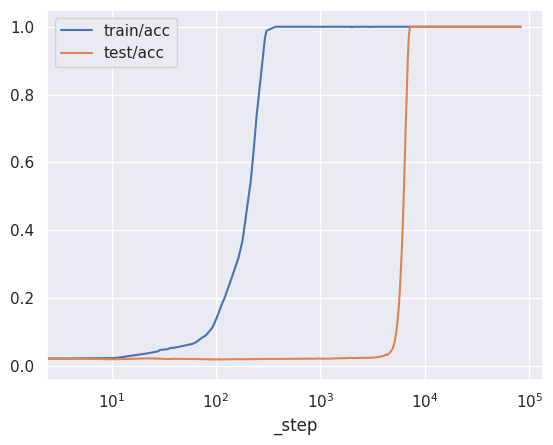

In [6]:
history.sort_values(by="_step", inplace=True)
history.plot(x="_step", y=["train/acc", "test/acc"], logx=True)

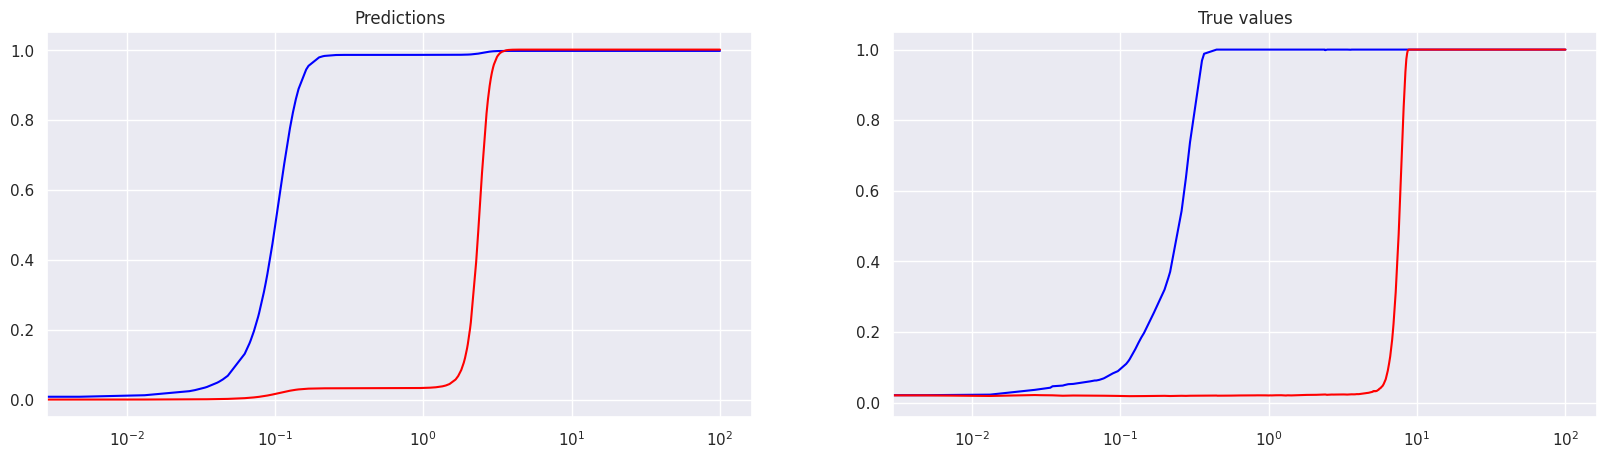

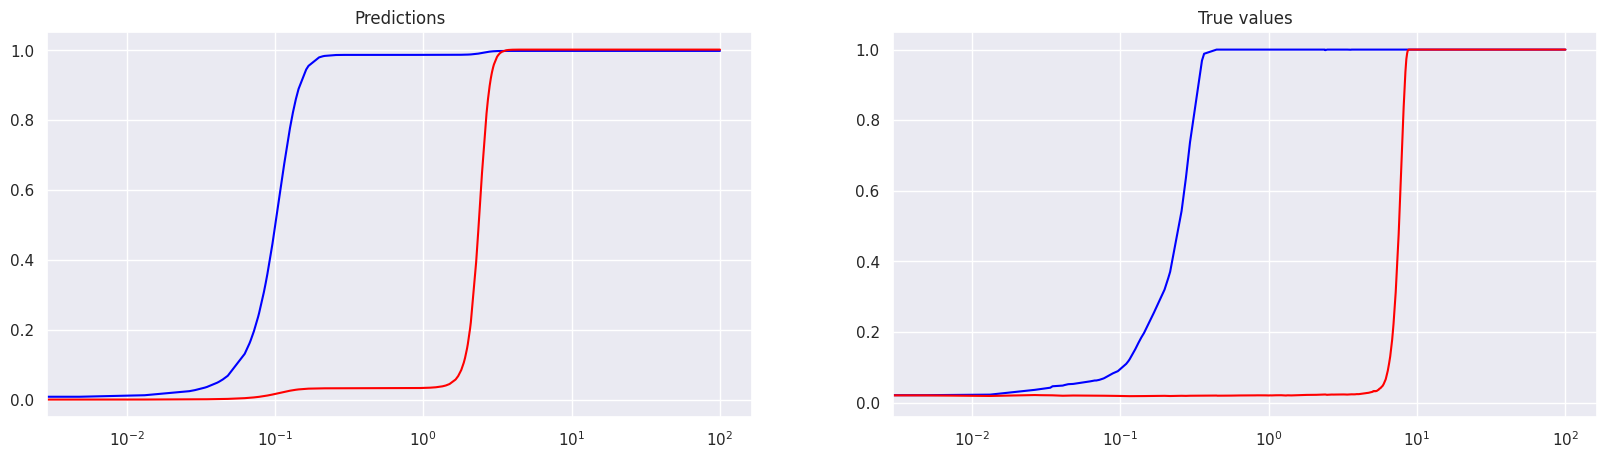

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.19045662879943848


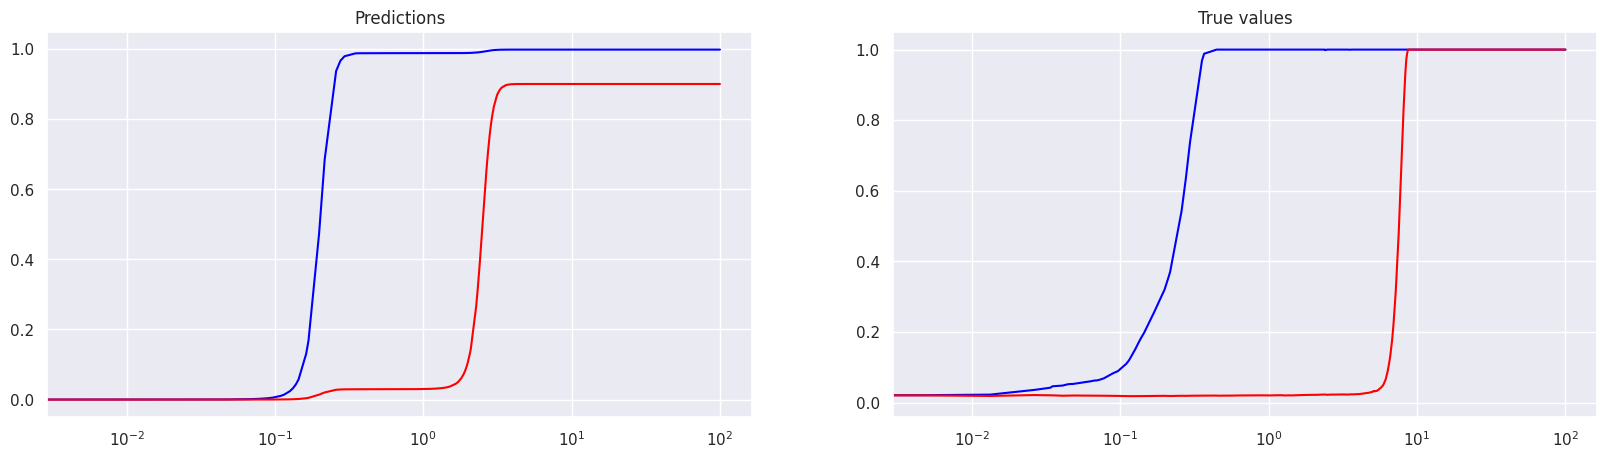

Epoch 1 - loss: 0.14339807629585266
Epoch 2 - loss: 0.1256166398525238
Epoch 3 - loss: 0.12233956903219223
Epoch 4 - loss: 0.12506365776062012
Epoch 5 - loss: 0.1281483769416809
Epoch 6 - loss: 0.1287722885608673
Epoch 7 - loss: 0.12701717019081116
Epoch 8 - loss: 0.12337727844715118
Epoch 9 - loss: 0.11836552619934082
Epoch 10 - loss: 0.11322905868291855
Epoch 11 - loss: 0.10835004597902298
Epoch 12 - loss: 0.1044471263885498
Epoch 13 - loss: 0.10146045684814453
Epoch 14 - loss: 0.09944810718297958
Epoch 15 - loss: 0.09830782562494278
Epoch 16 - loss: 0.0977494940161705
Epoch 17 - loss: 0.09723255038261414
Epoch 18 - loss: 0.09634695947170258
Epoch 19 - loss: 0.09471573680639267
Epoch 20 - loss: 0.09225969016551971
Epoch 21 - loss: 0.08941684663295746
Epoch 22 - loss: 0.08658518642187119
Epoch 23 - loss: 0.08397946506738663
Epoch 24 - loss: 0.08167804777622223
Epoch 25 - loss: 0.079643115401268
Epoch 26 - loss: 0.07774617522954941
Epoch 27 - loss: 0.07576906681060791
Epoch 28 - loss: 

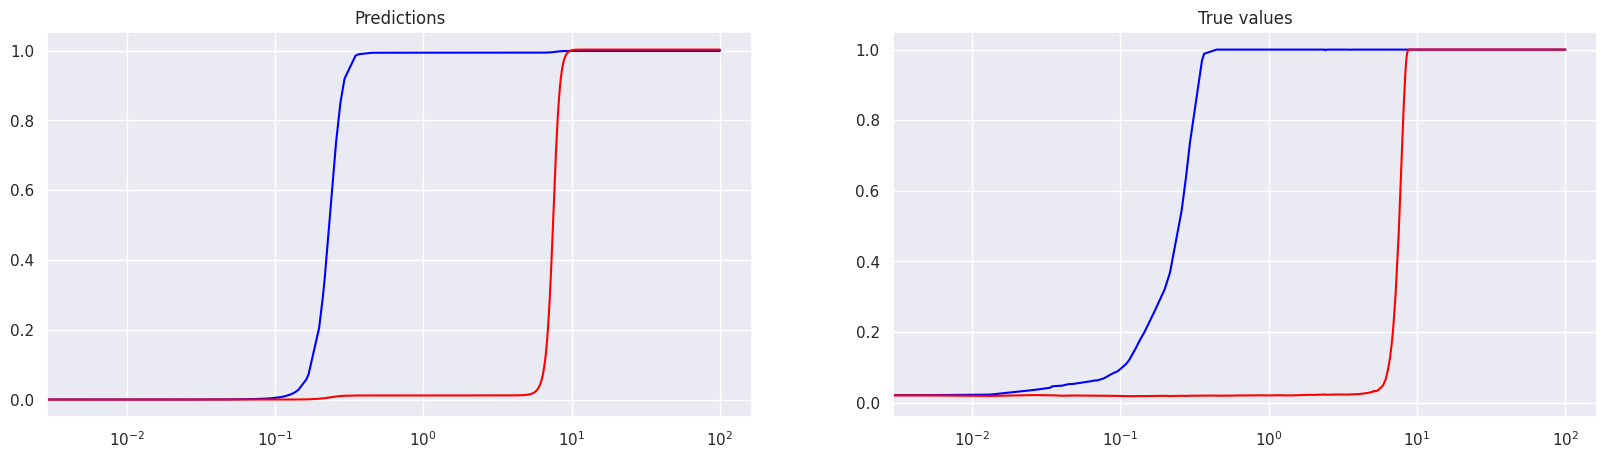

Epoch 101 - loss: 0.001014802954159677
Epoch 102 - loss: 0.0010082065127789974
Epoch 103 - loss: 0.001005136058665812
Epoch 104 - loss: 0.0010046132374554873
Epoch 105 - loss: 0.001005487167276442
Epoch 106 - loss: 0.001006652251817286
Epoch 107 - loss: 0.0010072420118376613
Epoch 108 - loss: 0.0010067186085507274
Epoch 109 - loss: 0.0010048248805105686
Epoch 110 - loss: 0.0010014824802055955
Epoch 111 - loss: 0.0009967101505026221
Epoch 112 - loss: 0.0009906112682074308
Epoch 113 - loss: 0.0009834030643105507
Epoch 114 - loss: 0.0009754293132573366
Epoch 115 - loss: 0.0009671109728515148
Epoch 116 - loss: 0.0009588593966327608
Epoch 117 - loss: 0.0009509875089861453
Epoch 118 - loss: 0.0009436823893338442
Epoch 119 - loss: 0.000937017728574574
Epoch 120 - loss: 0.0009310034802183509
Epoch 121 - loss: 0.0009256167686544359
Epoch 122 - loss: 0.000920803053304553
Epoch 123 - loss: 0.0009164647199213505
Epoch 124 - loss: 0.0009124549687840044
Epoch 125 - loss: 0.0009086013305932283
Epoch 

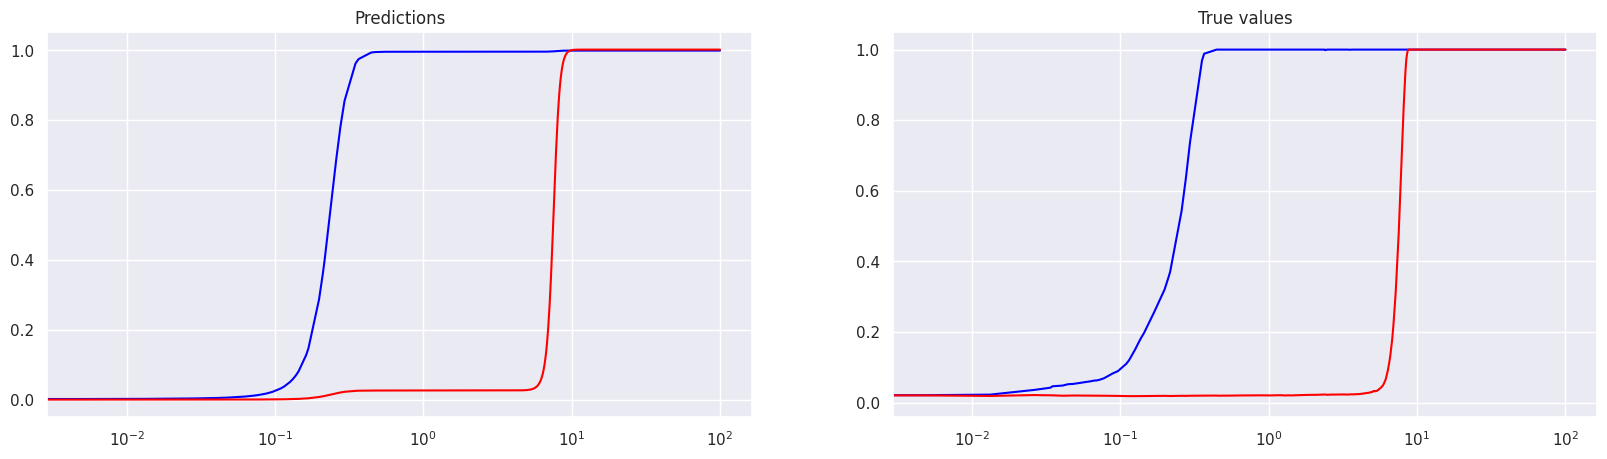

Epoch 201 - loss: 0.0005362811498343945
Epoch 202 - loss: 0.0005312974099069834
Epoch 203 - loss: 0.0005263104103505611
Epoch 204 - loss: 0.0005213202675804496
Epoch 205 - loss: 0.0005163275636732578
Epoch 206 - loss: 0.0005113324732519686
Epoch 207 - loss: 0.0005063359276391566
Epoch 208 - loss: 0.0005013385671190917
Epoch 209 - loss: 0.0004963406827300787
Epoch 210 - loss: 0.0004913429729640484
Epoch 211 - loss: 0.00048634674749337137
Epoch 212 - loss: 0.0004813529085367918
Epoch 213 - loss: 0.00047636142699047923
Epoch 214 - loss: 0.00047137372894212604
Epoch 215 - loss: 0.0004663914442062378
Epoch 216 - loss: 0.0004614141653291881
Epoch 217 - loss: 0.0004564437549561262
Epoch 218 - loss: 0.0004514814936555922
Epoch 219 - loss: 0.0004465284291654825
Epoch 220 - loss: 0.0004415854637045413
Epoch 221 - loss: 0.0004366543726064265
Epoch 222 - loss: 0.0004317359998822212
Epoch 223 - loss: 0.0004268320626579225
Epoch 224 - loss: 0.0004219436668790877
Epoch 225 - loss: 0.00041707308264449

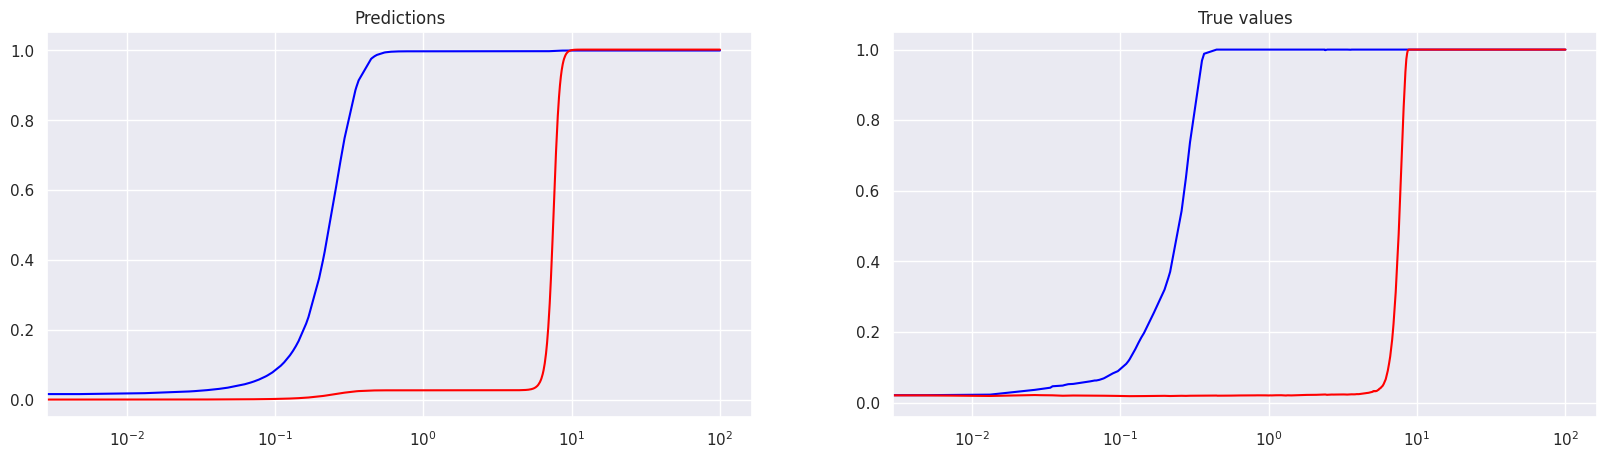

Epoch 301 - loss: 0.00020465614215936512
Epoch 302 - loss: 0.00020428854622878134
Epoch 303 - loss: 0.00020395181491039693
Epoch 304 - loss: 0.00020364382362458855
Epoch 305 - loss: 0.00020336326269898564
Epoch 306 - loss: 0.0002031074691331014
Epoch 307 - loss: 0.00020287517691031098
Epoch 308 - loss: 0.000202664450625889
Epoch 309 - loss: 0.0002024733548751101
Epoch 310 - loss: 0.0002023009437834844
Epoch 311 - loss: 0.00020214487449266016
Epoch 312 - loss: 0.0002020043903030455
Epoch 313 - loss: 0.00020187717746011913
Epoch 314 - loss: 0.000201762915821746
Epoch 315 - loss: 0.0002016598591580987
Epoch 316 - loss: 0.0002015675709117204
Epoch 317 - loss: 0.00020148427574895322
Epoch 318 - loss: 0.0002014094206970185
Epoch 319 - loss: 0.00020134169608354568
Epoch 320 - loss: 0.00020128088362980634
Epoch 321 - loss: 0.00020122526620980352
Epoch 322 - loss: 0.00020117522217333317
Epoch 323 - loss: 0.00020112935453653336
Epoch 324 - loss: 0.0002010878815781325
Epoch 325 - loss: 0.00020104

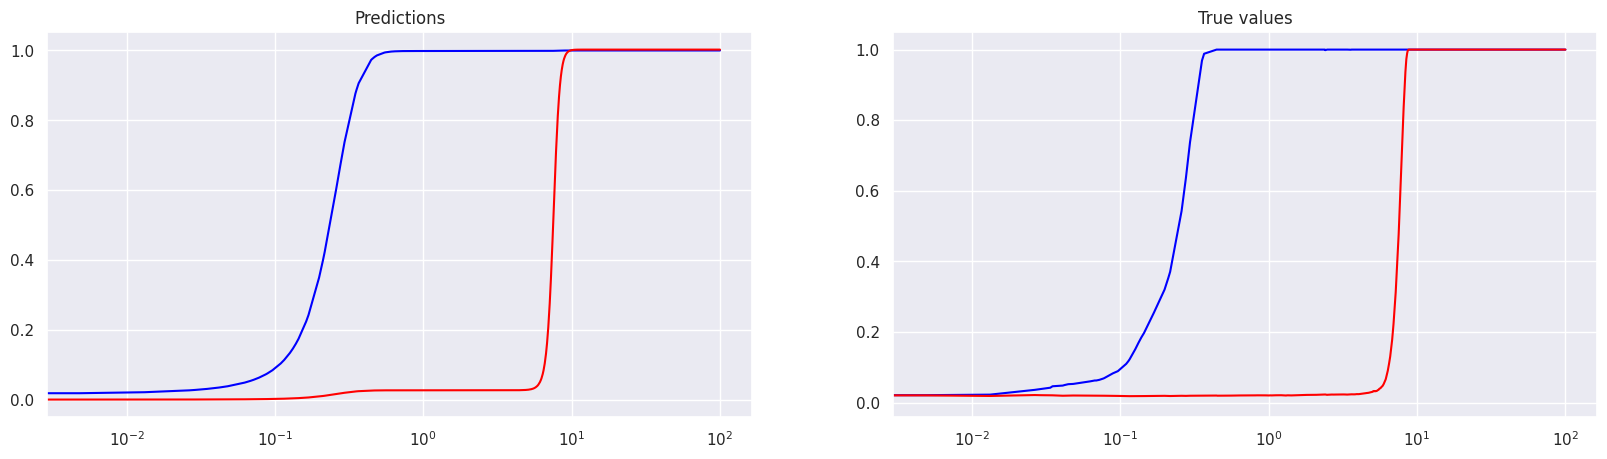

Epoch 401 - loss: 0.00019974942551925778
Epoch 402 - loss: 0.000199738351511769
Epoch 403 - loss: 0.00019972714653704315
Epoch 404 - loss: 0.00019971617439296097
Epoch 405 - loss: 0.00019970539142377675
Epoch 406 - loss: 0.0001996943319682032
Epoch 407 - loss: 0.000199683869141154
Epoch 408 - loss: 0.00019967317348346114
Epoch 409 - loss: 0.00019966259424109012
Epoch 410 - loss: 0.00019965189858339727
Epoch 411 - loss: 0.0001996418577618897
Epoch 412 - loss: 0.0001996312930714339
Epoch 413 - loss: 0.00019962112128268927
Epoch 414 - loss: 0.00019961065845564008
Epoch 415 - loss: 0.0001996010832954198
Epoch 416 - loss: 0.0001995909260585904
Epoch 417 - loss: 0.0001995807106141001
Epoch 418 - loss: 0.0001995713682845235
Epoch 419 - loss: 0.00019956132746301591
Epoch 420 - loss: 0.0001995517814066261
Epoch 421 - loss: 0.00019954200251959264
Epoch 422 - loss: 0.0001995327475015074
Epoch 423 - loss: 0.00019952311413362622
Epoch 424 - loss: 0.00019951393187511712
Epoch 425 - loss: 0.000199504

PatternLearningModel({'pattern_0/strength': tensor(0.9987), 'pattern_0/speed': tensor(17.2390), 'pattern_0/onset': tensor(0.2342), 'pattern_0/generalization': tensor(0.0271), 'pattern_1/strength': tensor(0.8621), 'pattern_1/speed': tensor(2.6239), 'pattern_1/onset': tensor(7.7610), 'pattern_1/generalization': tensor(2.1323)})

In [14]:
rescaled_run = rescale_run(history, new_max=100., log=False)
model = PatternLearningModel(num_patterns=2, max_time=100.)

# Initialization
for i, pattern in enumerate(model.patterns):
    max_time = 100
    pattern.onset.data = torch.tensor(0.1 * (0.25 * max_time) ** i)
    pattern.speed.data = torch.tensor((max_time / 2) * 10 ** (-i))
    # pattern._strength.data = pattern._inv_sigmoid(torch.tensor([.8, 1.0, 1.0][i]))
    # pattern._generalization.data = torch.log(torch.tensor([.3, 0.01, .69][i]))


def callback(x): 
    plot_patterns(x, rescaled_run, log=True)
    plt.show()

callback(model)

model.fit(rescaled_run, lr=0.1, num_epochs=500, callback=callback, callback_ivl=100)

/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


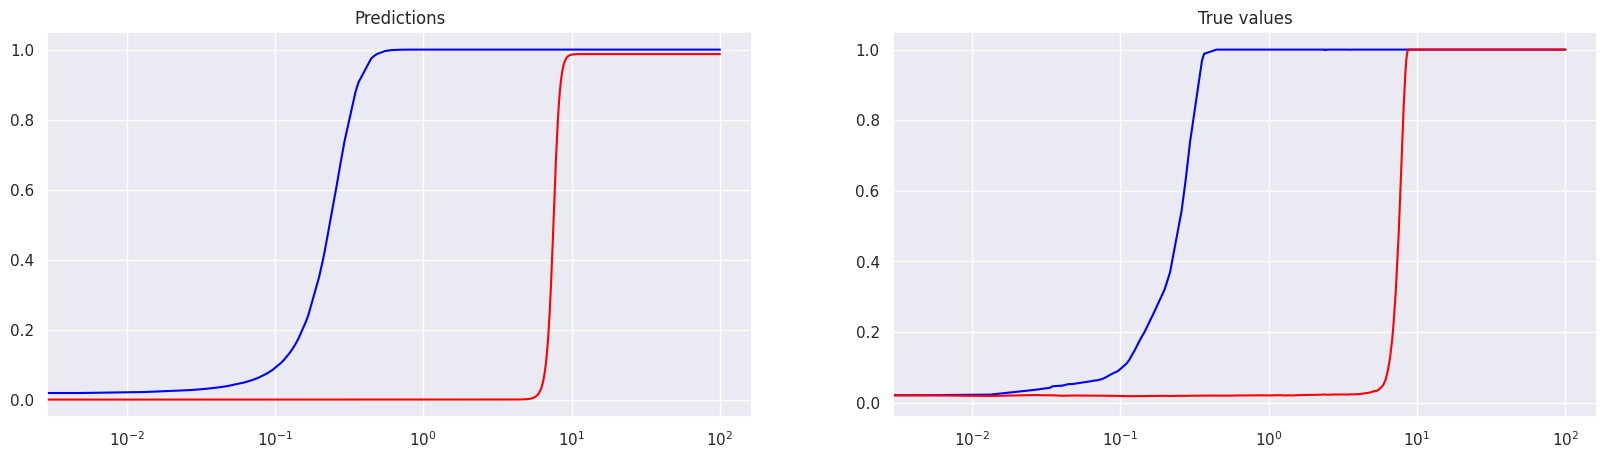

In [19]:
# Because of the way generalization & strength are parametrized, they can never reach 0.0 or 1.0, respectively. 
# Instead, we specify a threshold for the strength and generalization parameters, and use that to 
# determine whether a pattern is active or not, after training
eps = 0.03

for p in model.patterns:
    if p.strength > 1 - eps:
        p._strength.data *= torch.inf
        
    if p.generalization < eps:
        p._generalization.data += -torch.inf


callback(model)

In [48]:
# Pattern(strength=0.9986720085144043, speed=17.239028930664062, onset=0.2342032641172409, generalization=0.027139823883771896)
# model.rescale(100)
# Save grokking fit (it's not a torch model, so we can't use torch.save)

import pickle

with open("grokking_fit.pkl", "wb") as f:
    pickle.dump(model, f)

model.patterns

/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ModuleList(
  (0): Pattern(strength=1.0, speed=17.239028930664062, onset=0.2342032790184021, generalization=0.0)
  (1): Pattern(strength=0.8621257543563843, speed=2.6238951683044434, onset=7.760988712310791, generalization=2.1322953701019287)
)

/tmp/ipykernel_8336/1633985740.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])


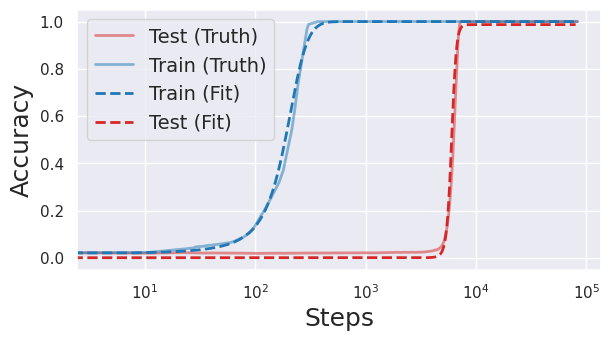

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

run = history

ax.plot(run["_step"], run["test/acc"], label="Test (Truth)", color=RED, linewidth=2, alpha=0.5)
ax.plot(run["_step"], run["train/acc"], label="Train (Truth)", color=BLUE, linewidth=2, alpha=0.5)
ax.set_ylabel("Accuracy", fontsize=18)
# ax.set_xlabel("Steps", fontsize=18)
# ax.set_xticklabels(["", "", "", "", "", ""], color="white")

min_, max_ = 0, 100
ts = torch.linspace(min_, max_, 10000)
TS = ts * 80_000 / 100
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax.plot(TS, train_ys, label="Train (Fit)", color=BLUE, linewidth=2, linestyle="--")
ax.plot(TS, test_ys, label="Test (Fit)", color=RED, linewidth=2, linestyle="--")
# ax.set_title("Fit", )
ax.legend(fontsize=14)

ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
# ax.set_xlim(10, 100)
ax.set_xscale("log")
# ax.set_xticks([0.01, 0.1, 1, 10, 100])

fig.tight_layout(pad=0.25)
ax.set_xlabel("Steps", fontsize=18)


# Already in log scale
# train_ys, test_ys

plt.savefig("../figures/grokking-fit.pdf", bbox_inches="tight")

In [50]:
def df_row_to_toy_model(row):
    model = PatternLearningModel(max_time=100.)

    for i, pattern in enumerate(model.patterns):
        pattern.onset.data = torch.tensor(row[f"pattern_{i}/onset"])
        pattern.speed.data = torch.tensor(row[f"pattern_{i}/speed"])
        pattern.strength.data = torch.tensor(row[f"pattern_{i}/strength"])
        pattern.generalization.data = torch.tensor(row[f"pattern_{i}/generalization"])

    return model

model = df_row_to_toy_model(model_entry)
model.rescale(100)
model


PatternLearningModel({'pattern_0/strength': tensor(0.0773, dtype=torch.float64), 'pattern_0/speed': tensor(0.0042, dtype=torch.float64), 'pattern_0/onset': tensor(3307.6699, dtype=torch.float64), 'pattern_0/generalization': tensor(0.0144, dtype=torch.float64), 'pattern_1/strength': tensor(0.9862, dtype=torch.float64), 'pattern_1/speed': tensor(0.0076, dtype=torch.float64), 'pattern_1/onset': tensor(4938.3472, dtype=torch.float64), 'pattern_1/generalization': tensor(0.7016, dtype=torch.float64), 'pattern_2/strength': tensor(0.9925, dtype=torch.float64), 'pattern_2/speed': tensor(0.0058, dtype=torch.float64), 'pattern_2/onset': tensor(7550.4229, dtype=torch.float64), 'pattern_2/generalization': tensor(6.9398, dtype=torch.float64)})

/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'Fit')

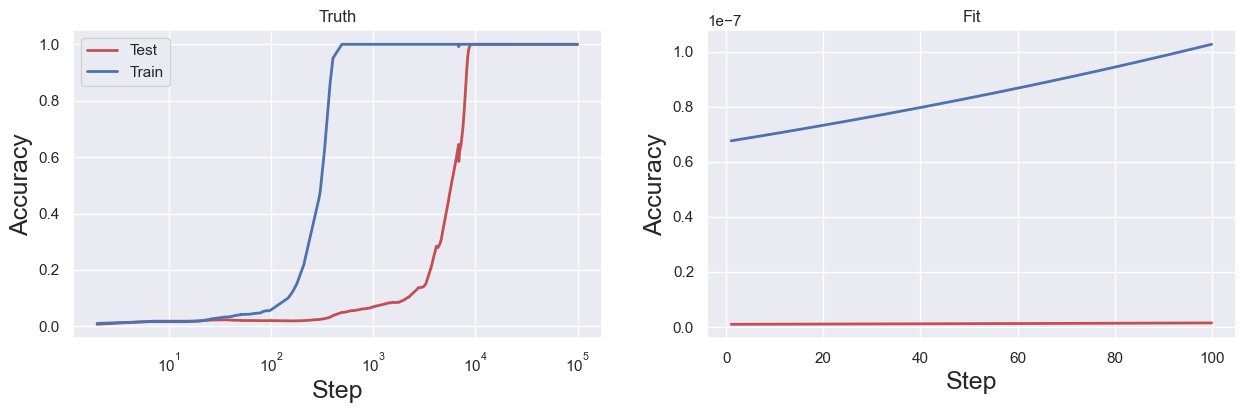

In [51]:
# Get corresponding original run
og_df = get_history(DM_SWEEP_ID, unique_cols="d_model")
run = og_df.loc[og_df.d_model==D_MODEL,:] #.plot(x="_step", y="test/acc")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(run["_step"], run["test/acc"], label="Test", color=RED, linewidth=2)
ax1.plot(run["_step"], run["train/acc"], label="Train", color=BLUE, linewidth=2)
ax1.set_ylabel("Accuracy", fontsize=18)
ax1.set_xlabel("Step", fontsize=18)
ax1.set_xscale("log")
ax1.legend()
ax1.set_title("Truth")

min_step, max_step = og_df["_step"].min(), 10000 # run["_step"].max()

ts = np.linspace(min_step, max_step, 1000)
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax2.plot(ts, train_ys, label="Train", color=BLUE, linewidth=2)
ax2.plot(ts, test_ys, label="Test", color=RED, linewidth=2)
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Step", fontsize=18)
ax2.set_title("Fit")

# Already in log scale
# train_ys, test_ys

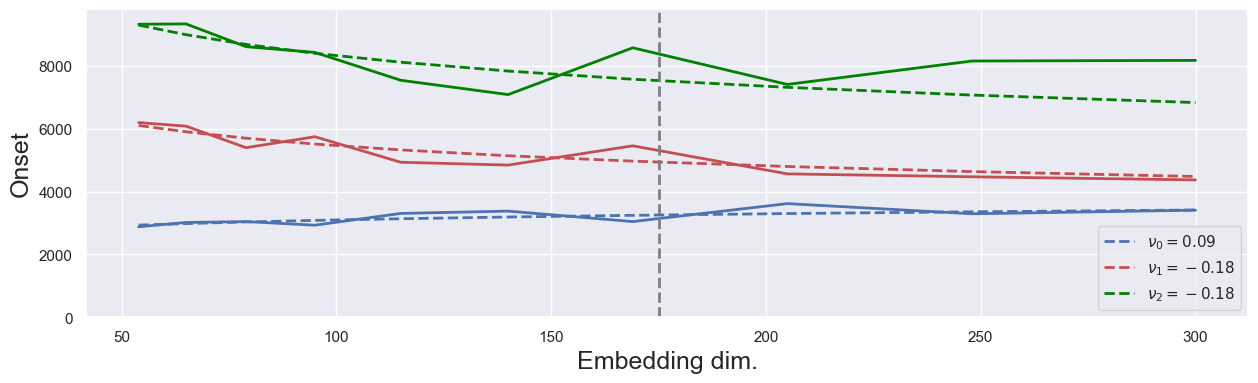

In [70]:
# Ignore any d_model < 50
df_cleaned = df.loc[df["d_model"] >= 50, :]
d_models = df_cleaned.loc[:, "d_model"].unique()

# Scaling analysis
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

colors = [BLUE, RED, "green"]
y_max = 0

for i in range(3):
    slice = df_cleaned.loc[:, f"pattern_{i}/onset"]
    y_max = max(y_max, slice.max())
    ax.plot(d_models, slice, label=f"", color=colors[i], linewidth=2)

ax.set_xlabel("d_model", fontsize=18)
ax.set_ylabel("Onset", fontsize=18)


# Fit a power-law to the onsets 
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x**b

def fit_power_law(x, y):
    popt, pcov = curve_fit(power_law, x, y)
    return popt


CUTOFF = 175

# Fit power law to onset
for i in range(3):
    # Train up to a specific point
    df_to_fit = df_cleaned.loc[df_cleaned["d_model"] <= CUTOFF, :]
    d_models_to_fit = df_to_fit.loc[:, "d_model"].unique()

    onset_popt = fit_power_law(d_models_to_fit, df_to_fit.loc[:, f"pattern_{i}/onset"])
    exponent = round(onset_popt[1], 2)
    ax.plot(d_models, power_law(d_models, *onset_popt), label=f"$\\nu_{i} = {exponent}$", color=colors[i], linestyle="--", linewidth=2)

ax.vlines(CUTOFF, 0, y_max * 1.05, color="grey", linestyle="--", linewidth=2)
ax.set_xlabel("Embedding dim.", fontsize=18)
ax.set_ylim(0, y_max * 1.05)

ax.legend()

In [ ]:
# Let's see if we can fit 